<a href="https://colab.research.google.com/github/Lera06/ImageCaptioning/blob/main/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# remove directory
# !rm -rf ./data_dir

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## 0. Setup device-agnostic code

In [1]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Download the COCO-2014 dataset


* This dataset consists of over **200,000 labeled images** with **5 captions** for each image.

In [2]:
# Install wget - it helps us to download the files
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=d63a671de40b6a745839ebdf1ba854296d4b83866266a4833ece50a8dc907d61
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [3]:
# Create a data directory
!mkdir data_dir

In [4]:
# Download images and annotations to the data directory
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir

--2025-04-15 06:42:22--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.177.155, 54.231.131.121, 3.5.25.234, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.177.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./data_dir/train2014.zip’

train2014.zip       100%[===================>]  12.58G  47.0MB/s    in 3m 46s  

2025-04-15 06:46:08 (57.0 MB/s) - ‘./data_dir/train2014.zip’ saved [13510573713/13510573713]

--2025-04-15 06:46:09--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.70.121, 3.5.22.61, 3.5.29.251, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.70.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘./data_dir/val2014.zip’

val2014.zip         10

In [6]:
# Extract zipped images and annotations and remove the zip files
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip
!unzip ./data_dir/val2014.zip -d ./data_dir/
!rm ./data_dir/val2014.zip
!unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
!rm ./data_dir/annotations_trainval2014.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: ./data_dir/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000036349.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000502055.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000438848.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000364973.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000564166.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000323327.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000338581.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000039656.jpg  
 extracting: ./data_dir/val2014/COCO

In [7]:
# Walk through each directory
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files/images in '{dirpath}'.")

In [8]:
walk_through_dir(dir_path='./data_dir')

There are 3 directories and 0 files/images in './data_dir'.
There are 0 directories and 82783 files/images in './data_dir/train2014'.
There are 0 directories and 6 files/images in './data_dir/annotations'.
There are 0 directories and 40504 files/images in './data_dir/val2014'.


## 2. Plot a Random Image

See the source of the code [here](https://github.com/sauravraghuvanshi/Udacity-Computer-Vision-Nanodegree-Program/blob/master/project_2_image_captioning_project/0_Dataset.ipynb).

In [9]:
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
instances_ann_file = os.path.join('data_dir/annotations/instances_train2014.json')
coco = COCO(instances_ann_file)

# initialize COCO API for caption annotations
captions_ann_file = os.path.join('data_dir/annotations/captions_train2014.json')
coco_caps = COCO(captions_ann_file)

# get annotation ids
list_anns_ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=10.95s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [10]:
list_anns_ids1 = sorted(list(coco.anns.keys()))
list_anns_ids1[:10]

[86, 89, 93, 113, 116, 126, 148, 152, 166, 172]

http://images.cocodataset.org/train2014/COCO_train2014_000000363956.jpg


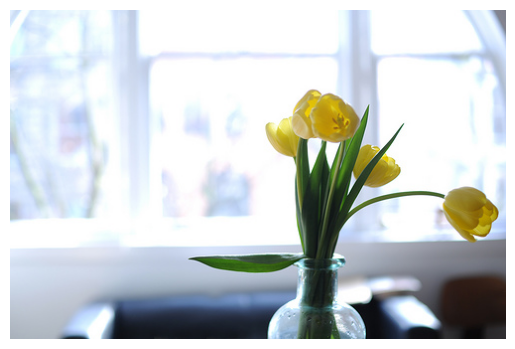

YELLOW FLOWERS IN A GLASS VASE IN FRONT OF A WINDOW
A flower vase with yellow flowers is sitting in a room.
A bunch of yellow flowers stands in a glass vase.
A vase with yellow flowers and a large window in the background.
A vase filled with yellow flowers on top of a table.


In [20]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(list_anns_ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis(False)
plt.imshow(I)
plt.show()

# load and display captions
ann_ids = coco_caps.getAnnIds(imgIds=img['id']) # a list with anns id
anns = coco_caps.loadAnns(ann_ids)
coco_caps.showAnns(anns)

## 3. Preprocessing Caption Data

In [21]:
import nltk
import pickle
from PIL import Image
from collections import Counter

nltk.download('punkt_tab') # allows us to tokenize a given text into constituent words

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [22]:
class Vocab:
  """Simple vocabulary wrapper."""
  def __init__(self):
    # word to index
    self.w2i = {}
    # index to word
    self.i2w = {}
    # initial index
    self.index = 0

  def __call__(self, token): # the inctance can be called like a function
    if not token in self.w2i:
      return self.w2i['<unk>']
    return self.w2i[token]

  def __len__(self):
    return len(self.w2i)

  def add_token(self, token):
    if not token in self.w2i:
      self.w2i[token] = self.index
      self.i2w[self.index] = token
      self.index += 1

In [23]:
# Build a vocabulary that can convert actual textual tokens
# (such as words) into numeric tokens

def build_vocabulary(json, threshold):
  """Build a vacabulary wrapper"""
  coco = COCO(json)
  counter = Counter()
  ids = coco.anns.keys()

  for i , id in enumerate(ids):
    caption = str(coco.anns[id]['caption'])
    # Individual words in the caption are tokenized: getting a list of string-valued tokens
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    # And stored in a counter
    counter.update(tokens) # {'token': counts}

    if (i+1) % 1000 == 0:
      print(f"[{i+1}/{len(ids)}] Tokenized the captions.")


  # If the word frequency is less than 'threshold', then the word is discarded.
  tokens = [token for token, cnt in counter.items() if cnt >= threshold]

  # Create a vocab wrapper and add some special tokens.
  vocab = Vocab()
  vocab.add_token('<pad>')     # 0
  vocab.add_token('<start>')   # 1
  vocab.add_token('<end>')     # 2
  vocab.add_token('<unk>')     # 3

  # Add the words to the vocabulary.
  for i, token in enumerate(tokens):
    vocab.add_token(token)
  return vocab

**Exploring how `coco.anns` works:**

In [24]:
coco = COCO('data_dir/annotations/captions_val2014.json')
ids = coco.anns.keys()

for i , id in enumerate(ids):
  if i == 0:
    print(f'i: {i}, id: {id}')
    caption = str(coco.anns[id]['caption'])

print(caption)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
i: 0, id: 37
A bicycle replica with a clock as the front wheel.


In [25]:
caption = str(coco.anns[37]['caption']) # image_id = 203564
print(caption)

A bicycle replica with a clock as the front wheel.


In [26]:
# get a list of anns id
anns_id = coco.getAnnIds(203564) # image_id
anns_id

[37, 181, 478, 6637, 6802]

In [27]:
anns = coco.loadAnns(anns_id)
anns

[{'image_id': 203564,
  'id': 37,
  'caption': 'A bicycle replica with a clock as the front wheel.'},
 {'image_id': 203564, 'id': 181, 'caption': 'The bike has a clock as a tire.'},
 {'image_id': 203564,
  'id': 478,
  'caption': 'A black metal bicycle with a clock inside the front wheel.'},
 {'image_id': 203564,
  'id': 6637,
  'caption': 'A bicycle figurine in which the front wheel is replaced with a clock\n'},
 {'image_id': 203564,
  'id': 6802,
  'caption': 'A clock with the appearance of the wheel of a bicycle '}]

In [ ]:
# coco.anns

In [28]:
# Build a vocabulary
vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json',
                         threshold=4)

vocab_path = './data_dir/vocabulary.pkl'

with open(vocab_path, 'wb') as f: # запись в двоичном режиме и сохранение в файл
    pickle.dump(vocab, f) # сериализация: объект -> поток байтов

print(f"Total vocabulary size: {len(vocab)}.")
print(f"Saved the vocabulary wrapper to '{vocab_path}'.")

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

## 4. Preprocessing Image Data

In [29]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [30]:
# Reshape images
def reshape_image(image, shape):
  """Resize an image to the given shape."""
  return image.resize(shape, Image.LANCZOS)


def reshape_images(image_path, output_path, shape):
  """Reshape the images in 'image_path' and save into 'output_path'."""
  if not os.path.exists(output_path):
    # Create a directory in the specified path
    os.makedirs(output_path)

  # Obtain a list of images in a specified path
  images = os.listdir(image_path)
  num_im = len(images)

  for i, im in enumerate(images):
    with open(os.path.join(image_path, im), 'r+b') as f: # read binary
      with Image.open(f) as image:
        image = reshape_image(image, shape)
        image.save(os.path.join(output_path, im), image.format)

    if (i+1) % 100 == 0:
      print (f"[{i+1}/{num_im}] Resized the images and saved into '{output_path}'.")

In [31]:
# Reshape all the images to a fixed shape [256, 256]
image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

[100/82783] Resized the images and saved into './data_dir/resized_images/'.
[200/82783] Resized the images and saved into './data_dir/resized_images/'.
[300/82783] Resized the images and saved into './data_dir/resized_images/'.
[400/82783] Resized the images and saved into './data_dir/resized_images/'.
[500/82783] Resized the images and saved into './data_dir/resized_images/'.
[600/82783] Resized the images and saved into './data_dir/resized_images/'.
[700/82783] Resized the images and saved into './data_dir/resized_images/'.
[800/82783] Resized the images and saved into './data_dir/resized_images/'.
[900/82783] Resized the images and saved into './data_dir/resized_images/'.
[1000/82783] Resized the images and saved into './data_dir/resized_images/'.
[1100/82783] Resized the images and saved into './data_dir/resized_images/'.
[1200/82783] Resized the images and saved into './data_dir/resized_images/'.
[1300/82783] Resized the images and saved into './data_dir/resized_images/'.
[1400/82

## 4. Create a Custom Dataset

We build a custom dataset that makes a tensor out of each caption.

In [32]:
# Implement our own Dataset
class CustomCocoDataset(data.Dataset):
  """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
  def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
    """Set the path for images, captions and vocabulary wrapper.
      Args:
        root: image directory.
        json: coco annotation file path.
        vocab: vocabulary wrapper.
        transform: image transformer.
    """
    self.root = data_path
    self.coco_data = COCO(coco_json_path)
    self.indices = list(self.coco_data.anns.keys())
    self.vocabulary = vocabulary
    self.transform = transform

  def __getitem__(self, idx):
    """Returns one data pair (image and caption)."""
    coco_data = self.coco_data
    vocabulary = self.vocabulary
    annotation_id = self.indices[idx]
    caption = coco_data.anns[annotation_id]['caption']
    image_id = coco_data.anns[annotation_id]['image_id']
    image_path = coco_data.loadImgs(image_id)[0]['file_name']

    image = Image.open(os.path.join(self.root, image_path)).convert('RGB')

    if self.transform is not None:
      image = self.transform(image)

    # Convert a caption to a PyTorch tensor
    # 1. Obtain a list of string-valued tokens
    word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
    # 2. Initialize an empty list
    caption = []
    # 3. Append an integer to indicate the start of a caption
    caption.append(vocabulary('<start>'))
    # 4. Kepp adding integers that correspond to each of the tokens in the caption
    caption.extend([vocabulary(token) for token in word_tokens])
    # 5. Append a final integer to indicate the end of the caption
    caption.append(vocabulary('<end>'))
    # 6. Convert the list of integers to a PyTorch tensor
    ground_truth = torch.Tensor(caption)

    return image, ground_truth

  def __len__(self):
    return len(self.indices)

**Exploring how `__getitem__` works**

In [33]:
# 0: Create a sample caption
sample_caption = 'Several adults and children are playing in the snow.'
print(sample_caption)
# 1:
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)
# 2:
sample_caption = []
# 3:
sample_caption.append(vocab('<start>'))
print(sample_caption)
# 4:
sample_caption.extend([vocab(token) for token in sample_tokens])
print(sample_caption)
# 5:
sample_caption.append(vocab('<end>'))
print(sample_caption)
# 6:
sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

Several adults and children are playing in the snow.
['several', 'adults', 'and', 'children', 'are', 'playing', 'in', 'the', 'snow', '.']
[1]
[1, 74, 780, 7, 292, 53, 356, 78, 33, 515, 19]
[1, 74, 780, 7, 292, 53, 356, 78, 33, 515, 19, 2]
tensor([  1,  74, 780,   7, 292,  53, 356,  78,  33, 515,  19,   2])


## 6. DataLoader

* Our captions are **variable-length sequences**.

* Before creating a data loader for our custom dataset, we need to write our own **collate function** to deal with **variable-length** captions.

In [34]:
def collate_function(data_batch):
  """Takes a list of tuples (image, caption), sampled from a dataset using
  its __getitem__ and collates them together into a batch that’s being
  returned by the data loader.
  Args:
    data: list of tuple (image, caption).
        - image: torch tensor of shape (3, 224, 224).
        - caption: torch tensor of shape with variable length.
  Returns:
    images: torch tensor of shape (batch_size, 3, 224, 224).
    targets: torch tensor of shape (batch_size, padded_length).
    lengths: list; valid length for each padded caption.
  """
  # Sort the batch by the length of captions in descending order
  data_batch.sort(key=lambda x: len(x[1]), reverse=True)
  imgs, caps = zip(*data_batch)

  # Merge images (from list of 3D tensors to 4D tensor).
  # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 224, 224)
  imgs = torch.stack(imgs, dim=0) # add one more dim

  # Merge captions (from list of 1D tensors to 2D tensor)
  cap_lens = [len(cap) for cap in caps]
  tgts = torch.zeros(len(caps), max(cap_lens)).long()

  for i, cap in enumerate(caps):
    end = cap_lens[i]
    tgts[i, :end] = cap[:end]

  return imgs, tgts, cap_lens

**Explore how the `collate function` works**

In [35]:
# 1. Create an example dataset
# Load vocabulary
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Create transformations
transform = transforms.Compose([
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))])

# Create a dataset
dataset = CustomCocoDataset(data_path='data_dir/resized_images',
                            coco_json_path='data_dir/annotations/captions_train2014.json',
                            vocabulary=vocabulary,
                            transform=transform)

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


In [36]:
# 2. Create a list of tuples (image, caption) to explore how collate function works
data = [dataset[0], dataset[1]]
print(data)
print(data[0][0].shape) # -> torch.Size([3, 224, 224])

[(tensor([[[-1.6898, -1.5870, -1.2959,  ...,  0.1939,  0.1768,  0.1939],
         [-1.5699, -1.3473, -1.1418,  ...,  0.1083,  0.2282,  0.2624],
         [-1.6384, -1.5870, -1.4500,  ...,  0.1597,  0.2624,  0.3309],
         ...,
         [ 0.4337,  0.4508,  0.4851,  ...,  0.5707,  0.5878,  0.6049],
         [ 0.4166,  0.3823,  0.3652,  ...,  0.5878,  0.6049,  0.6049],
         [ 0.4508,  0.4508,  0.4337,  ...,  0.5878,  0.5878,  0.5878]],

        [[-1.2829, -1.2304, -0.9153,  ...,  0.7829,  0.7654,  0.7654],
         [-1.2129, -1.0203, -0.8452,  ...,  0.7479,  0.7654,  0.7654],
         [-1.3004, -1.2654, -1.1779,  ...,  0.6954,  0.7129,  0.6954],
         ...,
         [ 0.5903,  0.6078,  0.6429,  ...,  0.6779,  0.6779,  0.6954],
         [ 0.5728,  0.5378,  0.5203,  ...,  0.6954,  0.6954,  0.6954],
         [ 0.6078,  0.6078,  0.5903,  ...,  0.6954,  0.6779,  0.6779]],

        [[-1.0201, -0.9504, -0.6890,  ...,  1.2282,  1.2805,  1.3328],
         [-0.8633, -0.6541, -0.5147,  ..., 

In [37]:
# 3. Sort data by caption length in descending order
data.sort(key=lambda x: len(x[1]), reverse=True)
# Then create a list of tuples [(all images), (all captions)]
imgs, caps = zip(*data)
imgs, caps

((tensor([[[-1.2445,  0.3823, -0.2684,  ..., -2.0665, -2.1008, -2.1008],
           [-1.2274,  0.4166, -0.2342,  ..., -2.0665, -2.1008, -2.1008],
           [-1.1075,  0.4337, -0.2513,  ..., -2.0665, -2.0665, -2.0665],
           ...,
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],
  
          [[-1.8957, -0.3375, -0.7577,  ..., -2.0357, -2.0357, -2.0357],
           [-1.9307, -0.3725, -0.7577,  ..., -2.0357, -2.0357, -2.0357],
           [-1.8782, -0.4251, -0.8627,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],
  
          [[-1.8044, -0.8284, -1.2293,  ..., -1.7347, -1.7173, -1.7173],
           

In [38]:
# 4. Stack the images together
imgs = torch.stack(imgs, dim=0)
imgs, imgs.shape # -> torch.Size([2, 3, 224, 224]))

(tensor([[[[-1.2445,  0.3823, -0.2684,  ..., -2.0665, -2.1008, -2.1008],
           [-1.2274,  0.4166, -0.2342,  ..., -2.0665, -2.1008, -2.1008],
           [-1.1075,  0.4337, -0.2513,  ..., -2.0665, -2.0665, -2.0665],
           ...,
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.1008]],
 
          [[-1.8957, -0.3375, -0.7577,  ..., -2.0357, -2.0357, -2.0357],
           [-1.9307, -0.3725, -0.7577,  ..., -2.0357, -2.0357, -2.0357],
           [-1.8782, -0.4251, -0.8627,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182]],
 
          [[-1.8044, -0.8284, -1.2293,  ..., -1.7347, -1.7173, -1.7173],
           [-

In [39]:
# 5. Compute the original sizes of captions
cap_lens = [len(cap) for cap in caps]
print(cap_lens)
tgts = torch.zeros(len(caps), max(cap_lens)).long()
print(tgts)

[14, 10]
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [40]:
# 6. Create a tensor filled with the padded captions
for i, cap in enumerate(caps):
  end = cap_lens[i]
  print(end)
  tgts[i, :end] = cap[:end]
  print(tgts)

14
tensor([[ 1,  4, 12, 13, 14,  4, 15,  7, 16, 14, 17, 18, 19,  2],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
10
tensor([[ 1,  4, 12, 13, 14,  4, 15,  7, 16, 14, 17, 18, 19,  2],
        [ 1,  4,  5,  6,  7,  8,  9, 10, 11,  2,  0,  0,  0,  0]])


In [41]:
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
  """Returns torch.utils.data.DataLoader for custom coco dataset."""

  # COCO caption dataset
  coco_dataset = CustomCocoDataset(data_path=data_path,
                                   coco_json_path=coco_json_path,
                                   vocabulary=vocabulary,
                                   transform=transform)

  # Data loader for COCO dataset
  # This will return (images, captions, lengths) for each iteration.
  # images: a tensor of shape (batch_size, 3, 224, 224).
  # captions: a tensor of shape (batch_size, padded_length).
  # lengths: a list indicating valid length for each caption.
  custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=shuffle,
                                                   num_workers=num_workers,
                                                   collate_fn=collate_function)
  return custom_data_loader

**Explore how `get_loader` works**

In [42]:
# Create a train_loader
train_loader = get_loader(data_path='data_dir/resized_images',
                          coco_json_path='data_dir/annotations/captions_train2014.json',
                          vocabulary=vocabulary,
                          transform=transform,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


In [43]:
image_cap_length = next(iter(train_loader)) # returns a tuple (images, captions, lengths)
image, cap, length = image_cap_length
print(f'image shape: {image.shape}')
print(f'caption shape: {cap.shape}')
print(f'valid length for each caption: {length}')
print(f'batch size: {len(length)}')

image shape: torch.Size([128, 3, 224, 224])
caption shape: torch.Size([128, 30])
valid length for each caption: [30, 20, 20, 19, 19, 19, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
batch size: 128


In [44]:
# The first three captions converted to Pytorch tensor
cap[:3]

tensor([[   1,   33,  114,  823,  192,   14,    4, 2361,  205,   87,   22,    4,
           33, 3866,   78,    4, 1353, 3848,    7,   33, 4599,    7, 4551,  286,
         1023,   33, 2126,  205,   19,    2],
        [   1,    4,  170,  879,    4,  371,  857,   22,    4, 2514,  864,  208,
          361,    4,  864,  162,  161, 1590,   19,    2,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   1,   33,   15,  131,    6,    7, 1417,   22,   17,   75,  731,    7,
          653,  654,  234,   40,   33,   25,   19,    2,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]])

## 7. Build a Model

### 7.1 CNN Model

* We will use a pre-trained `CNN model` available under the PyTorch models repository: the **ResNet-152** architecture.
* We remove the last layer of this pre-trained ResNet model and replace it with a fully-connected layer followed by a batch normalization layer.
* The `CNN model` will generate an embedding vector for each image. This embedding is then fed to the `LSTM model`.

**Explore `ResNet-152` model**

In [45]:
!pip install -q torchinfo
from torchinfo import summary

In [46]:
# Load pre-trained ResNet-152 model
weights=models.ResNet152_Weights.DEFAULT
model = models.resnet152(weights=weights).to(device)

# Getting a summary of the model
summary(model=model,
        input_size=(128, 3, 224, 224),
        # col_names=["input_size"], # version for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"] # what features to show in a row
)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 123MB/s]


Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [128, 3, 224, 224]        [128, 1000]               --                        True
├─Conv2d (conv1)                         [128, 3, 224, 224]        [128, 64, 112, 112]       9,408                     True
├─BatchNorm2d (bn1)                      [128, 64, 112, 112]       [128, 64, 112, 112]       128                       True
├─ReLU (relu)                            [128, 64, 112, 112]       [128, 64, 112, 112]       --                        --
├─MaxPool2d (maxpool)                    [128, 64, 112, 112]       [128, 64, 56, 56]         --                        --
├─Sequential (layer1)                    [128, 64, 56, 56]         [128, 256, 56, 56]        --                        True
│    └─Bottleneck (0)                    [128, 64, 56, 56]         [128, 256, 56, 56]        --                        True
│    │ 

In [47]:
# Get all the children (layers) of the ResNet-152 model
list(model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [48]:
# Remove the last FC layer
list(model.children())[:-1]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [49]:
# Get the number of input features to the last FC layer
model.fc.in_features

2048

In [50]:
class CNNModel(nn.Module):
  def __init__(self, embedding_size):
    """Load the pretrained ResNet-152 and replace top fc layer."""
    super(CNNModel, self).__init__()

    # Load a pre-trained CNN model: the ResNet 152
    weights=models.ResNet152_Weights.DEFAULT
    resnet = models.resnet152(weights=weights)

    # Delete the last FC layer
    module_list = list(resnet.children())[:-1]
    self.resnet_module = nn.Sequential(*module_list)

    # Replace it with a new FC layer
    self.linear_layer = nn.Linear(in_features=resnet.fc.in_features, # 2048
                                  out_features=embedding_size)

    # Add a batch normalization layer
    self.batch_norm = nn.BatchNorm1d(embedding_size,
                                     momentum=0.01)

  def forward(self, input_images):
    """Extract feature vectors from input images."""
    with torch.no_grad():
      resnet_features = self.resnet_module(input_images) # torch.Size([128, 2048, 1, 1])
      # print(f'resnet_features shape before resheping: {resnet_features.shape}')

    resnet_features = resnet_features.reshape(resnet_features.size(0), -1) # torch.Size([128, 2048])
    # print(f'resnet_features shape after resheping:{resnet_features.shape}')

    final_features = self.batch_norm(self.linear_layer(resnet_features))   # torch.Size([128, 256])
    # print(f'final_features shape: {final_features.shape}')

    return final_features # torch.Size([128, 256])

**Explore the `CNN model`**

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = CNNModel(embedding_size=256).to(device)

# Obtain the batch
image_caption_length = next(iter(train_loader)) # returns a tuple (images, captions, lengths)
image, caption, length = image_cap_length

print(f'image.shape: {image.shape}')       # torch.Size([128, 3, 224, 224])
print(f'caption.shape: {caption.shape}')   # torch.Size([128, 23])

# Pass the images through the encoder
features = encoder(image.to(device))

print(f'type(features): {type(features)}')
print(f'features.shape: {features.shape}')

image.shape: torch.Size([128, 3, 224, 224])
caption.shape: torch.Size([128, 30])
type(features): <class 'torch.Tensor'>
features.shape: torch.Size([128, 256])


### 7.2 LSTM Model

In [52]:
class LSTMModel(nn.Module):
  def __init__(self,
               embedding_size,      # input_size = 256
               hidden_layer_size,   # hidden_size = 512
               vocabulary_size,
               num_layers,
               max_seq_len=20):
    """Set the hyper-parameters and build the layers."""
    super(LSTMModel, self).__init__()

    # Embedding layer turns words into a vector of a specified size
    self.embedding_layer = nn.Embedding(num_embeddings=vocabulary_size,
                                        embedding_dim=embedding_size)
    # Simple LSTM model
    # Takes embedded word vectors as input
    self.lstm_layer = nn.LSTM(input_size=embedding_size,
                              hidden_size=hidden_layer_size,
                              num_layers=num_layers,
                              batch_first=True)

    self.linear_layer = nn.Linear(in_features=hidden_layer_size,
                                  out_features=vocabulary_size)
    self.max_seq_len = max_seq_len

  def forward(self, input_features, captions, lens):
    """Decode image feature vectors and generates captions."""

    # Create embedded word vectors for each word in the captions
    embeddings = self.embedding_layer(captions) # shape : (batch_size, (caption length-1), embed_size)
    # print(f'embeddings shape: {embeddings.shape}')

    # Concat the input features from the CNN model with the embeddings (captions)
    embeddings = torch.cat((input_features.unsqueeze(dim=1), embeddings), dim=1) # shape : (batch_size, caption length, embed_size)
    # print(f'embeddings shape: {embeddings.shape}')

    # Convert an already padded sequence into a packed sequence
    lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) # -> PackedSequence
    # print(f'lstm_input batch size: {lstm_input.batch_sizes}, {type(lstm_input)}')

    # Pass the packed sequence to LSTM as input
    output_packed, _ = self.lstm_layer(lstm_input) # -> PackedSequence
    # print(f'output_packed batch size: {output_packed.batch_sizes}, {type(output_packed)}')
    # print(f'output_packed\n: {output_packed}')
    # print(f'output_packed[0]\n: {type(output_packed[0])}') # -> torch.Tensor

    # Linear layer takes a torch.Tensor as input not a PackedSequence
    model_outputs = self.linear_layer(output_packed[0])
    # print(f'model_outputs shape: {model_outputs.shape}')

    return model_outputs # shape: (batch_sum_seq_len, vocabulary_size)

  def generate(self, input_features, lstm_states=None):
    """Generate captions for given image features using greedy search."""

    sampled_indices = []
    lstm_inputs = input_features.unsqueeze(dim=1)

    for i in range(self.max_seq_len):
      hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states) # hiddens: (batch_size, 1, hidden_size)

      model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
      # print(f'model_outputs: {model_outputs.shape}')

      _, predicted_outputs = model_outputs.max(1)                               # predicted: (batch_size)
      # print(f'predicted_outputs: {predicted_outputs.shape}')

      sampled_indices.append(predicted_outputs)

      lstm_inputs = self.embedding_layer(predicted_outputs)                     # inputs: (batch_size, embed_size)
      # print(f'lstm_inputs: {lstm_inputs.shape}')

      lstm_inputs = lstm_inputs.unsqueeze(1)                                    # inputs: (batch_size, 1, embed_size)
      # print(f'lstm_inputs: {lstm_inputs.shape}')

    sampled_indices = torch.stack(sampled_indices, 1)                           # sampled_ids: (batch_size, max_seq_length)

    return sampled_indices

**Explore `LSTM` model**

In [53]:
# Initialize the encoder and decoder.
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)

# Obtain the batch
image_caption_length = next(iter(train_loader))
image = image_cap_length[0].to(device)
print(f'image: {image.shape}')
caption = image_cap_length[1].to(device)
print(f'caption: {caption.shape}') # padded length
length = image_cap_length[2]
print(f'length: {length}')

# Pass the images through the encoder
features = encoder_model(image)
print(f'features.shape: {features.shape}')

# Pass the encoder output and captions through the decoder.
outputs = decoder_model(features, caption, length)
print(f'outputs shape: {outputs.shape}') # shape: (batch_sum_seq_len, vocabulary_size)

image: torch.Size([128, 3, 224, 224])
caption: torch.Size([128, 30])
length: [30, 20, 20, 19, 19, 19, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
features.shape: torch.Size([128, 256])
outputs shape: torch.Size([1686, 9948])


In [ ]:
# batch_sum_seq_len = sum(length)

**Explore the `generate()` method**

In [54]:
# Get one image from our train dataloader
image = dataset[0][0].to(device)
image = image.unsqueeze(dim=0)
print(image.shape)

torch.Size([1, 3, 224, 224])


In [55]:
# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

In [56]:
encoder = CNNModel(embedding_size=256).eval().to(device)
decoder = LSTMModel(256, 512, len(vocabulary), 1).to(device)

# Pass the images through the encoder
features = encoder(image)
sampled_indices = decoder.generate(features)
print(sampled_indices)
print(sampled_indices.shape)

tensor([[9660, 5652,  618, 8866, 8220, 7057, 5744, 4294, 6937, 5002, 5180, 8188,
         2636, 8375, 3672, 1768, 9099, 7076, 6958, 5598]])
torch.Size([1, 20])


## 8. Models' Configurations

In [57]:
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')


# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build data loader
custom_data_loader = get_loader(data_path='data_dir/resized_images',
                                coco_json_path='data_dir/annotations/captions_train2014.json',
                                vocabulary=vocabulary,
                                transform=transform,
                                batch_size=128,
                                shuffle=True,
                                num_workers=2)


# Build the models
encoder_model = CNNModel(embedding_size=256).to(device)
decoder_model = LSTMModel(embedding_size=256,
                          hidden_layer_size=512,
                          vocabulary_size=len(vocabulary),
                          num_layers=1).to(device)


# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


## 9. Training the CNN-LSTM Model

In [58]:
total_num_steps = len(custom_data_loader)

for epoch in range(2):
  for i, (imgs, caps, lens) in enumerate(custom_data_loader):

    # Set mini-batch dataset
    imgs = imgs.to(device)
    caps = caps.to(device)
    tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

    # Forward, backward and optimize
    feats = encoder_model(imgs)
    outputs = decoder_model(feats, caps, lens)
    loss = loss_fn(outputs, tgts)
    decoder_model.zero_grad()
    encoder_model.zero_grad()
    loss.backward()
    optimizer.step()

    # Print log info
    if i % 10 == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch+1, 3, i, total_num_steps, loss.item(), np.exp(loss.item()))) # Evaluation of the language model

    # Save the model checkpoints
    if (i+1) % 1000 == 0:
      torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
      torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

## 10. Generate image captions using the trained model

### 1. Load the trained model

In [60]:
# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to('cpu')
decoder_model = decoder_model.to('cpu')

In [61]:
# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt',
                                         map_location=torch.device("cpu")))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt',
                                         map_location=torch.device("cpu")))

<All keys matched successfully>

### 2. Load a vocabulary wrapper

In [62]:
with open('data_dir/vocabulary.pkl', 'rb') as f:
  vocabulary = pickle.load(f)

### 3. Load an image

In [63]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [74]:
# Load image
image_file_path = 'fiat.jpeg'


# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

def load_image(image_file_path, transform=None):
  img = Image.open(image_file_path).convert('RGB')
  img = img.resize([224, 224], Image.LANCZOS)

  if transform is not None:
    img = transform(img).unsqueeze(0)

  return img

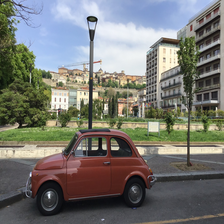

In [75]:
load_image(image_file_path=image_file_path)

In [76]:
def generate_caption_for_image(img):
  # Prepare an image
  img = load_image(image_file_path, transform)
  img_tensor = img.to(device)

  # Generate an caption from the image
  feat = encoder_model(img_tensor)
  sampled_indices = decoder_model.generate(feat)
  sampled_indices = sampled_indices[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

  # Convert word_ids to words
  predicted_caption = []
  for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
      break
  predicted_sentence = f"Predicted sentence:\n{' '.join(predicted_caption)}"

  # Print out the image and the generated caption
  print(predicted_sentence)
  img = Image.open(image_file_path)
  plt.imshow(np.asarray(img))
  plt.axis('off')
  plt.show()

Predicted sentence:
<start> a car is parked on a street with a sign on it . <end>


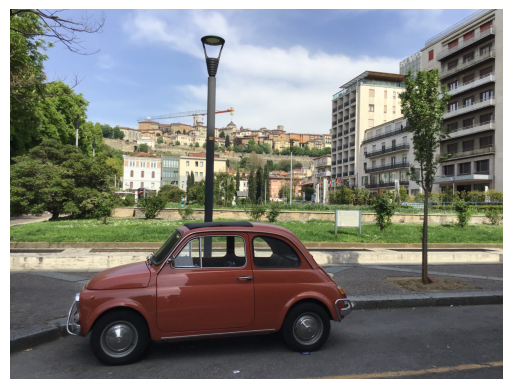

In [77]:
generate_caption_for_image(img=img)

## 11. Create a Gradio demo

### 11.1 Create a demo folder to keep app files

In [78]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
image_captioning_demo_path = Path("demo/image_captioning/")

# Remove files that might already exist there and create new directory
if image_captioning_demo_path.exists():
    shutil.rmtree(image_captioning_demo_path)
# If the file doesn't exist, create it anyway
image_captioning_demo_path.mkdir(parents=True,
                                 exist_ok=True)

### 11.2 Create a folder of example images to use with the Image Captioning demo

In [79]:
# Create a folder of example images to use with our Image Caption demo
import shutil
from pathlib import Path

# 1. Create an examples directory
image_captioning_examples_path = image_captioning_demo_path / "examples"
image_captioning_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
image_captioning_examples = [Path('data_dir/train2014/COCO_train2014_000000000706.jpg'),
                             Path('data_dir/train2014/COCO_train2014_000000197384.jpg'),
                             Path('data_dir/train2014/COCO_train2014_000000001639.jpg'),
                             Path('data_dir/train2014/COCO_train2014_000000001792.jpg')
                          ]

# 3. Copy the three random images to the examples directory
for example in image_captioning_examples:
  destination = image_captioning_demo_path / "examples"
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example, dst=destination)

[INFO] Copying data_dir/train2014/COCO_train2014_000000000706.jpg to demo/image_captioning/examples
[INFO] Copying data_dir/train2014/COCO_train2014_000000197384.jpg to demo/image_captioning/examples
[INFO] Copying data_dir/train2014/COCO_train2014_000000001639.jpg to demo/image_captioning/examples
[INFO] Copying data_dir/train2014/COCO_train2014_000000001792.jpg to demo/image_captioning/examples


In [80]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(image_captioning_examples_path)]
example_list

[['examples/COCO_train2014_000000001639.jpg'],
 ['examples/COCO_train2014_000000000706.jpg'],
 ['examples/COCO_train2014_000000197384.jpg'],
 ['examples/COCO_train2014_000000001792.jpg']]

In [81]:
# Check what's in the folder
!ls demo/image_captioning/examples

COCO_train2014_000000000706.jpg  COCO_train2014_000000001792.jpg
COCO_train2014_000000001639.jpg  COCO_train2014_000000197384.jpg


### 11.2 Build a Gradio APP

### 11.3 Moving the trained model to the demo directory

In [82]:
import shutil

# Create a source path for the target model
encoder_model_path = "models_dir/encoder-2-3000.ckpt"
decoder_model_path = "models_dir/decoder-2-3000.ckpt"

# Create a destination path for the target model
encoder_model_destination = image_captioning_demo_path / encoder_model_path.split("/")[1]
decoder_model_destination = image_captioning_demo_path / decoder_model_path.split("/")[1]

# Try to move the file
print(f"[INFO] Attempting to move {encoder_model_path} to {encoder_model_destination}")
print(f"[INFO] Attempting to move {decoder_model_path} to {decoder_model_destination}")

# Move the model
shutil.move(src=encoder_model_path,
            dst=encoder_model_destination)
shutil.move(src=decoder_model_path,
            dst=decoder_model_destination)

print(f"[INFO] Model move complete.")

[INFO] Attempting to move models_dir/encoder-2-3000.ckpt to demo/image_captioning/encoder-2-3000.ckpt
[INFO] Attempting to move models_dir/decoder-2-3000.ckpt to demo/image_captioning/decoder-2-3000.ckpt
[INFO] Model move complete.


### 11.4 Moving the vocabulary to the demo directory

In [83]:
import shutil

vocab_path = 'data_dir/vocabulary.pkl'

# Create a source path for the vocabulary
vocabulary_path = vocab_path

# Create a destination path for the vocabulary
vocabulary_destination = image_captioning_demo_path / vocab_path.split("/")[1]

# Try to move the file
print(f"[INFO] Attempting to move {vocabulary_path} to {vocabulary_destination}")

# Move the vocabulary
shutil.move(src=vocabulary_path,
            dst=vocabulary_destination)

print(f"[INFO] Vocabulary move complete.")

[INFO] Attempting to move data_dir/vocabulary.pkl to demo/image_captioning/vocabulary.pkl
[INFO] Vocabulary move complete.


### 11.5 Create `app.py`

In [100]:
%%writefile demo/image_captioning/app.py

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet152_Weights
import gradio as gr
import pickle
import os

# -----------------------------------------------------------------
# 0. SETUP DEVICE AGNOSTIC CODE
# -----------------------------------------------------------------

DEVICE = "cpu"

# -----------------------------------------------------------------
# 1. BUILD A VOCABULARY
# -----------------------------------------------------------------

class Vocab:
  """Simple vocabulary wrapper."""
  def __init__(self):
    # word to index
    self.w2i = {}
    # index to word
    self.i2w = {}
    # initial index
    self.index = 0

  def __call__(self, token):
    if not token in self.w2i:
      return self.w2i['<unk>']
    return self.w2i[token]

  def __len__(self):
    return len(self.w2i)

  def add_token(self, token):
    if not token in self.w2i:
      self.w2i[token] = self.index
      self.i2w[self.index] = token
      self.index += 1


def build_vocabulary(json, threshold):
  """Build a vacabulary"""
  coco = COCO(json)
  counter = Counter()
  ids = coco.anns.keys()

  for i , id in enumerate(ids):
    caption = str(coco.anns[id]['caption'])
    # Individual words in the caption are tokenized
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    # And stored in a counter
    counter.update(tokens)

    if (i+1) % 1000 == 0:
      print(f"[{i+1}/{len(ids)}] Tokenized the captions.")


  # If the word frequency is less than 'threshold', then the word is discarded
  tokens = [token for token, cnt in counter.items() if cnt >= threshold]

  # Create a vocab wrapper and add some special tokens
  vocab = Vocab()
  vocab.add_token('<pad>')     # 0
  vocab.add_token('<start>')   # 1
  vocab.add_token('<end>')     # 2
  vocab.add_token('<unk>')     # 3

  # Add the words to the vocabulary
  for i, token in enumerate(tokens):
    vocab.add_token(token)
  return vocab

# -----------------------------------------------------------------
# 2. MODEL ARCHITECTURE
# -----------------------------------------------------------------

# ENCODER
class CNNModel(nn.Module):
  def __init__(self,
               embedding_size):
    """Load the pretrained ResNet-152 and replace top FC layer."""
    super(CNNModel, self).__init__()

    # Load a pre-trained ResNet 152
    weights=models.ResNet152_Weights.DEFAULT
    resnet = models.resnet152(weights=weights)

    # Delete the last FC layer
    module_list = list(resnet.children())[:-1]
    self.resnet_module = nn.Sequential(*module_list)

    # Replace it with a new FC layer
    self.linear_layer = nn.Linear(in_features=resnet.fc.in_features,
                                  out_features=embedding_size)

    # Add a batch normalization layer
    self.batch_norm = nn.BatchNorm1d(embedding_size,
                                     momentum=0.01)

  def forward(self, input_images):
    """Extract feature vectors from input images."""
    with torch.no_grad():
      resnet_features = self.resnet_module(input_images) # torch.Size([128, 2048, 1, 1])
    resnet_features = resnet_features.reshape(resnet_features.size(0), -1) # torch.Size([128, 2048])
    final_features = self.batch_norm(self.linear_layer(resnet_features)) # torch.Size([batch, embedding_size])

    return final_features

# DECODER
class LSTMModel(nn.Module):
  def __init__(self,
               embedding_size,
               hidden_layer_size,
               vocabulary_size,
               num_layers,
               max_seq_len=20):
    """Set the hyper-parameters and build the layers."""
    super(LSTMModel, self).__init__()

    # Embedding layer turns words into a vector of a specified size
    self.embedding_layer = nn.Embedding(num_embeddings=vocabulary_size,
                                        embedding_dim=embedding_size)
    # Simple LSTM model
    # Takes embedded word vectors as input
    self.lstm_layer = nn.LSTM(input_size=embedding_size,
                              hidden_size=hidden_layer_size,
                              num_layers=num_layers,
                              batch_first=True)

    self.linear_layer = nn.Linear(in_features=hidden_layer_size,
                                  out_features=vocabulary_size)
    self.max_seq_len = max_seq_len

  def forward(self, input_features, captions, lens):
    """Decode image feature vectors and generates captions."""

    # Create embedded word vectors for each word in the captions
    embeddings = self.embedding_layer(captions) # shape : (batch_size, (caption length-1), embed_size)

    # Concat the input features from the CNN model with the embeddings (captions)
    embeddings = torch.cat((input_features.unsqueeze(dim=1), embeddings), dim=1) # shape : (batch_size, caption length, embed_size)

    # Convert an already padded sequence into a packed sequence
    lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) # -> PackedSequence

    # Pass the packed sequence to LSTM as input
    output_packed, _ = self.lstm_layer(lstm_input) # -> PackedSequence

    # Linear layer takes a torch.Tensor as input not a PackedSequence
    model_outputs = self.linear_layer(output_packed[0]) # shape: (batch_sum_seq_len, vocabulary_size)

    return model_outputs

  def generate_indices(self, input_features, lstm_states=None):
    """Generate captions for given image features using greedy search."""

    sampled_indices = []
    lstm_inputs = input_features.unsqueeze(dim=1)

    for i in range(self.max_seq_len):
      hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states) # hiddens: (batch_size, 1, hidden_size)
      model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
      _, predicted_outputs = model_outputs.max(1)                               # predicted: (batch_size)
      sampled_indices.append(predicted_outputs)
      lstm_inputs = self.embedding_layer(predicted_outputs)                     # inputs: (batch_size, embed_size)
      lstm_inputs = lstm_inputs.unsqueeze(1)                                    # inputs: (batch_size, 1, embed_size)
    sampled_indices = torch.stack(sampled_indices, 1)                           # sampled_ids: (batch_size, max_seq_length)

    return sampled_indices

# -----------------------------------------------------------------
# 3. LOAD THE TRAINED MODEL
# -----------------------------------------------------------------

# Load the vocabulary
with open('vocabulary.pkl', 'rb') as f:
  vocabulary = pickle.load(f)


def load_trained_model():
  encoder_model = CNNModel(embedding_size=256).eval()  # eval mode (batchnorm uses moving mean/variance)
  decoder_model = LSTMModel(embedding_size=256,
                            hidden_layer_size=512,
                            vocabulary_size=len(vocabulary),
                            num_layers=1)

  encoder_model = encoder_model.to(DEVICE)
  decoder_model = decoder_model.to(DEVICE)

  # Load the trained model parameters
  encoder_model.load_state_dict(torch.load('encoder-2-3000.ckpt',
                                          map_location=torch.device("cpu")))
  decoder_model.load_state_dict(torch.load('decoder-2-3000.ckpt',
                                          map_location=torch.device("cpu")))
  return encoder_model, decoder_model

encoder_model, decoder_model = load_trained_model()

# -----------------------------------------------------------------
# 4. INFERENCE FUNCTION (FOR GRADIO)
# -----------------------------------------------------------------

# Image preprocessing
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ]
)
def generate_caption_for_image(img):
  # Prepare an image
  img = img.convert('RGB')
  img_tensor = transform(img).unsqueeze(0)

  img_tensor = img_tensor.to(DEVICE)

  # Generate an caption from the image
  features = encoder_model(img_tensor)
  sampled_indices = decoder_model.generate_indices(features)
  sampled_indices = sampled_indices[0].cpu().numpy()

  # Convert word_ids to words
  predicted_caption = []
  for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
      break
  predicted_sentence = f"Predicted sentence:\n{' '.join(predicted_caption)}"

  return predicted_sentence

# -----------------------------------------------------------------
# 5. BUILD GRADIO INTERFACE
# -----------------------------------------------------------------

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

demo = gr.Interface(
        fn=generate_caption_for_image,
        inputs=gr.Image(type="pil"),
        outputs="text",
        title="Image Captioning",
        description="Upload an image to get a generated caption from the trained model.",
        # Create examples list from "examples/" directory
        examples=example_list,
    )

demo.launch(share=True)

Overwriting demo/image_captioning/app.py


In [ ]:
# %run -i demo/image_caption/app.py

In [85]:
%%writefile demo/image_captioning/requirements.txt

torch
torchvision
gradio

Writing demo/image_captioning/requirements.txt


In [102]:
!ls demo/image_captioning

app.py		     encoder-2-3000.ckpt  requirements.txt
decoder-2-3000.ckpt  examples		  vocabulary.pkl


In [101]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demo/image_captioning && zip -r ../image_captioning.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
  from google.colab import files
  files.download("demo/image_captioning.zip")
except:
  print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: app.py (deflated 69%)
updating: decoder-2-3000.ckpt (deflated 7%)
updating: encoder-2-3000.ckpt (deflated 7%)
updating: examples/ (stored 0%)
updating: examples/COCO_train2014_000000001639.jpg (deflated 5%)
updating: examples/COCO_train2014_000000000706.jpg (deflated 0%)
updating: examples/COCO_train2014_000000197384.jpg (deflated 0%)
updating: examples/COCO_train2014_000000001792.jpg (deflated 0%)
updating: requirements.txt (deflated 8%)
updating: vocabulary.pkl (deflated 45%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>